In [1]:
import os, datetime
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import geopandas as gpd

In [2]:
import matplotlib.pyplot as plt
import contextily

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
data_id = gpd.read_file('data/train_dataset_id.geojson').fillna(0).reset_index(drop=True)
data_id_test = gpd.read_file('data/test_dataset_id.geojson').fillna(0.0).reset_index(drop=True)
data_ts = pd.read_csv('data/train_dataset_base.csv').fillna(0.0).reset_index(drop=True)
data_ts_test = pd.read_csv('data/test_dataset_base.csv').fillna(0.0).reset_index(drop=True)

# Plots

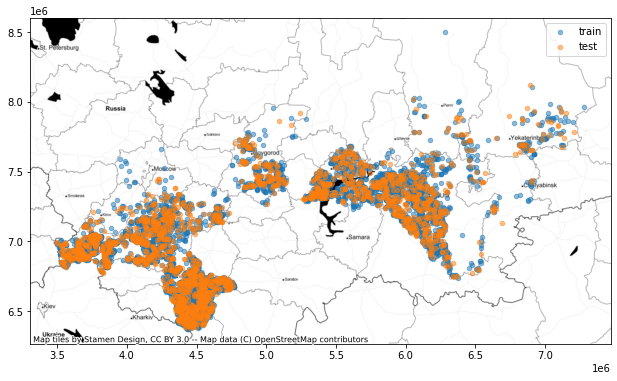

In [20]:
fig = plt.figure(figsize=(12,6))
base = data_id.to_crs(3857).geometry.centroid.plot(ax=plt.gca(), alpha=0.5, linewidth=1, markersize=20)
data_id_test.to_crs(3857).geometry.centroid.plot(ax=base, alpha=0.5, linewidth=1, markersize=20)
plt.legend(('train', 'test'))
contextily.add_basemap(base, source=contextily.providers.Stamen.Toner, crs=3857)
plt.savefig('presentation/images/map.png', dpi=200, bbox_inches='tight')

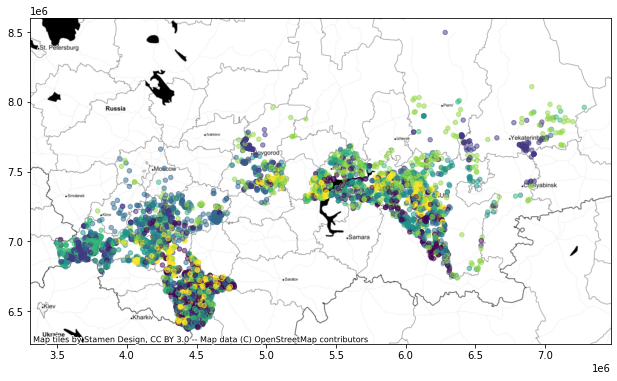

In [25]:
fig = plt.figure(figsize=(12,6))
base = data_id.to_crs(3857).geometry.centroid.plot(ax=plt.gca(), alpha=0.5, linewidth=1, markersize=20, c=data_id['crop'].astype(int))
contextily.add_basemap(base, source=contextily.providers.Stamen.Toner, crs=3857)

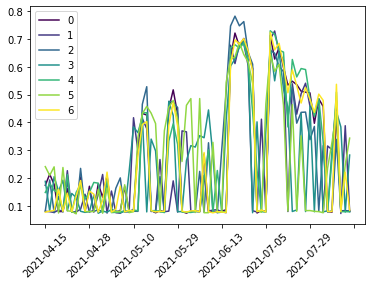

In [38]:
plt.figure(figsize=(6,4))
ax=plt.gca()
plot_data = data_ts.groupby(data_id['crop']).mean().T
plot_data.plot(ax=ax, cmap='viridis')
plt.legend(plot_data.columns)
ax.tick_params(axis='x', labelrotation=45)
plt.savefig('presentation/images/ts.png', dpi=200, bbox_inches='tight')

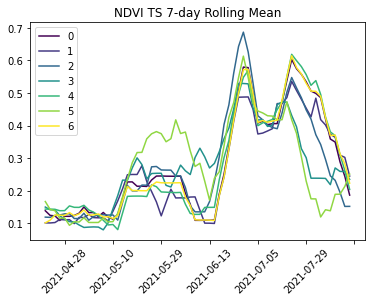

In [40]:
plt.figure(figsize=(6,4))
ax=plt.gca()
plot_data = data_ts.groupby(data_id['crop']).mean().T.rolling(7).mean()
plot_data.plot(ax=ax, cmap='viridis')
plt.legend(plot_data.columns)
plt.title('NDVI TS 7-day Rolling Mean')
ax.tick_params(axis='x', labelrotation=45)
plt.savefig('presentation/images/ts_roll.png', dpi=200, bbox_inches='tight')

# Sklearn Models

In [ ]:
bad_id = 2932
data_id = gpd.read_file('data/train_dataset_id.geojson').fillna(0).drop(bad_id).reset_index(drop=True)
data_id_test = gpd.read_file('data/test_dataset_id.geojson').fillna(0.0).reset_index(drop=True)
data_ts = pd.read_csv('data/train_dataset_base.csv').fillna(0.0).drop(bad_id).reset_index(drop=True)
data_ts_test = pd.read_csv('data/test_dataset_base.csv').fillna(0.0).reset_index(drop=True)

In [139]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score

In [155]:
data_ts_train, data_ts_val, data_id_train, data_id_val = train_test_split(data_ts, data_id, test_size=0.2, random_state=1)

In [156]:
data_train = data_ts_train
data_val = data_ts_val

In [157]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=1)
rf.fit(data_train, data_id_train['crop'])

RandomForestClassifier(random_state=1)

In [158]:
preds = rf.predict(data_val)
print(recall_score(preds, data_id_val['crop'], average='macro'))

0.9353023383211081


In [13]:
from sklearn.ensemble import GradientBoostingClassifier
cb = GradientBoostingClassifier(n_estimators=500, random_state=1)
cb.fit(data_train, data_id_train['crop'])

GradientBoostingClassifier(n_estimators=500, random_state=1)

In [14]:
preds = cb.predict(data_val)
print(recall_score(preds, data_id_val['crop'], average='macro'))

0.9519818869148222


# TSNE

In [41]:
bad_id = 2932
data_id = gpd.read_file('data/train_dataset_id.geojson').fillna(0).drop(bad_id).reset_index(drop=True)
data_id_test = gpd.read_file('data/test_dataset_id.geojson').fillna(0.0).reset_index(drop=True)
data_ts = pd.read_csv('data/train_dataset_base.csv').fillna(0.0).drop(bad_id).reset_index(drop=True)
data_ts_test = pd.read_csv('data/test_dataset_base.csv').fillna(0.0).reset_index(drop=True)

In [42]:
from sklearn.manifold import TSNE
import seaborn as sns

In [43]:
alg = TSNE(random_state=1)
tsne = alg.fit_transform(data_ts.values)

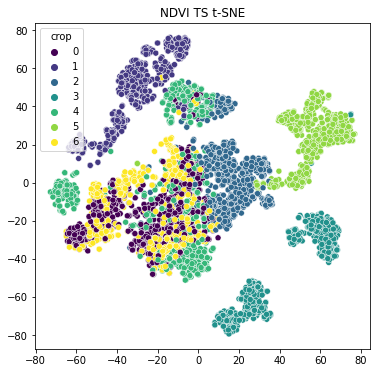

In [47]:
plt.figure(figsize=(6,6))
sns.scatterplot(*tsne.T, hue=data_id['crop'].astype(int), palette='viridis')
plt.title('NDVI TS t-SNE')
plt.savefig('presentation/images/ts_tsne.png', dpi=200, bbox_inches='tight')

## Test

In [48]:
base_hidden = pd.read_csv('presentation/data/base_hidden.csv')
avg_hidden = pd.read_csv('presentation/data/avg_hidden.csv')
y_pred = pd.read_csv('presentation/data/y_pred.csv')
y_true = pd.read_csv('presentation/data/y_true.csv')

In [50]:
alg1 = TSNE(random_state=1)
tsne_avg = alg1.fit_transform(avg_hidden.values)
alg2 = TSNE(random_state=1)
tsne_base = alg2.fit_transform(base_hidden.values)

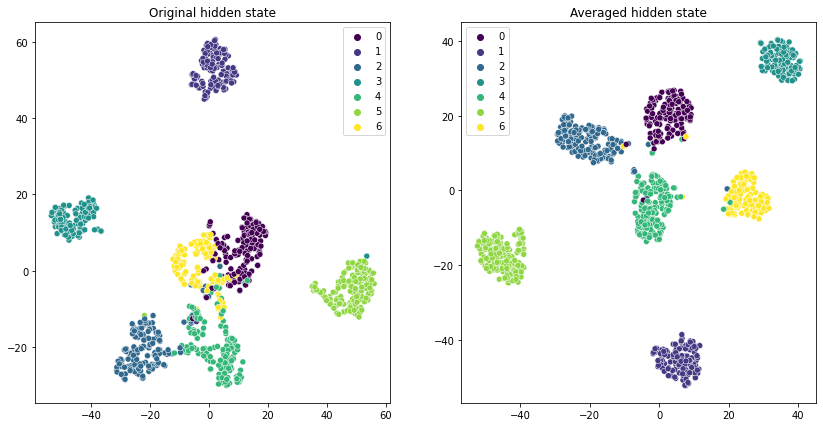

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(14,7))
sns.scatterplot(*tsne_base.T, hue=y_true.values.squeeze(), palette='viridis', ax=ax[0])
ax[0].set_title('Original hidden state')
sns.scatterplot(*tsne_avg.T, hue=y_true.values.squeeze(), palette='viridis', ax=ax[1])
ax[1].set_title('Averaged hidden state')
plt.savefig('presentation/images/hid_tsne.png', dpi=200, bbox_inches='tight')

<AxesSubplot:>

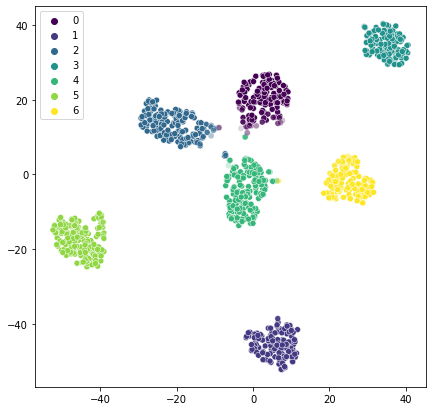

In [79]:
fig = plt.figure(figsize=(7,7))
alpha = (y_pred.values.max(1) - y_pred.values.max(1).min()) / (y_pred.values.max(1).max() - y_pred.values.max(1).min())
sns.scatterplot(*tsne_avg.T, hue=y_pred.values.argmax(1), alpha=alpha, palette='viridis')

In [102]:
from sklearn.metrics import recall_score
recalls = recall_score(y_pred.values.argmax(1), y_true, average=None)
recall_avg = recall_score(y_pred.values.argmax(1), y_true, average='macro')
print(recall_avg)
print(', '.join(f'{i}:{round(r,3)}' for i, r in zip(range(7), recalls)))

0.9847598441675521
0:0.952, 1:1.0, 2:0.987, 3:1.0, 4:0.987, 5:1.0, 6:0.968


In [104]:
pd.DataFrame({'class': np.arange(7), 'recall': recalls})

,class,recall
0,0,0.951724
1,1,1.000000
2,2,0.986928
3,3,1.000000
4,4,0.986667
5,5,1.000000
6,6,0.968000


In [96]:
recalls

array([0.95172414, 1.        , 0.9869281 , 1.        , 0.98666667,
       1.        , 0.968     ])